In [1]:
import torch.nn as nn
import torch.optim as optim
import torch_geometric.utils
import torch, random, torchaudio, os, time, math, torch_geometric
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
from torchvision import transforms as transforms
import torchaudio.transforms as audio_transforms
import datasets
from torch.utils.data import random_split, DataLoader
import utils

sample_rate = 16000
resample_rate = 8000
args = utils.Args(seed=42, N=3, K=3, query_size=3 ,SNR=0)

if args.device != "cpu":
    num_workers = 1
    pin_memory = True
    torch.cuda.manual_seed(args.seed)
else:
    num_workers = 0
    pin_memory = False
    torch.manual_seed(args.seed)

mimii_dataset = datasets.MIMII(root_dir='./data/mimii/0dB_SNR', N=3, K=3, query_size=3, transform='spectrogram')
print(f"Length of Dataset: {len(mimii_dataset)}")
train_size = int(0.2 * len(mimii_dataset))
test_size = len(mimii_dataset) - train_size
train_set, test_set = random_split(mimii_dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
print(f"Train Size:{train_size}  |  Test Size:{test_size}")

Length of Dataset: 33
Train Size:6  |  Test Size:27


波形形状: torch.Size([8, 513, 1251])
波形采样率: 16000


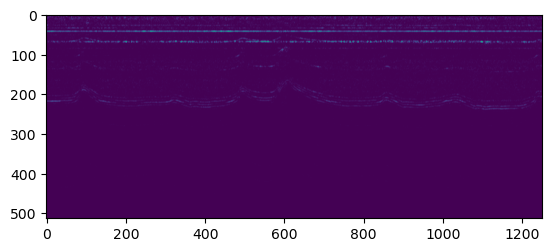

In [2]:
waveform_shape = 0
for support_set, _ in train_loader:
    for waveform, label in support_set:
        waveform = waveform.squeeze(0)
        print("波形形状: {}".format(waveform.size()))
        print("波形采样率: {}".format(sample_rate))
        if len(waveform.shape) == 3: # 转换过的2D波形
            plt.imshow(waveform[0])
        else: # 1D 纯波形
            plt.plot(waveform[0].T.numpy())
        waveform_shape = waveform.shape
        break
    break

Epoch:1  |  CNN_Loss :3.951
Epoch:2  |  CNN_Loss :1.294
Epoch:3  |  CNN_Loss :0.659
Epoch:4  |  CNN_Loss :0.601
Epoch:5  |  CNN_Loss :0.499
Epoch:6  |  CNN_Loss :0.382
Epoch:7  |  CNN_Loss :0.318
Epoch:8  |  CNN_Loss :0.220
Epoch:9  |  CNN_Loss :0.221
Epoch:10  |  CNN_Loss :0.229
Epoch:11  |  CNN_Loss :0.345
Epoch:12  |  CNN_Loss :0.232
Epoch:13  |  CNN_Loss :0.203
Epoch:14  |  CNN_Loss :0.350
Epoch:15  |  CNN_Loss :0.211
Epoch:16  |  CNN_Loss :0.248
Epoch:17  |  CNN_Loss :0.244
Epoch:18  |  CNN_Loss :0.325
Epoch:19  |  CNN_Loss :0.288
Epoch:20  |  CNN_Loss :0.220
Epoch:21  |  CNN_Loss :0.234
Epoch:22  |  CNN_Loss :0.261
Epoch:23  |  CNN_Loss :0.249
Epoch:24  |  CNN_Loss :0.247
Epoch:25  |  CNN_Loss :0.294
Epoch:26  |  CNN_Loss :0.221
Epoch:27  |  CNN_Loss :0.210
Epoch:28  |  CNN_Loss :0.217
Epoch:29  |  CNN_Loss :0.329
Epoch:30  |  CNN_Loss :0.367
Epoch:31  |  CNN_Loss :0.258
Epoch:32  |  CNN_Loss :0.205


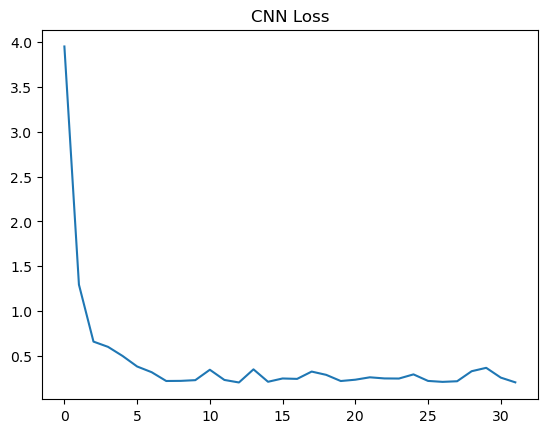

In [5]:
def cnn_train(cnn, train_loader, num_epochs, lr, device):

    def init_weights(module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv1d):
            nn.init.xavier_uniform_(module.weight)

    optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    loss_function = nn.CrossEntropyLoss()

    cnn.to(device).train()
    cnn.apply(init_weights)
    losses = []

    for epoch in range(1, num_epochs+1):
        metric = utils.Accumulator(2) # 一个epoch经过样本数 cnn一个epoch所有样本损失总量
        for support_set, query_set in train_loader:
            waveforms, labels = [], []
            for waveform, label in support_set:
                waveforms.append(waveform.squeeze(0)),
                labels.append(label)
            for waveform, label in query_set:
                waveforms.append(waveform.squeeze(0)),
                labels.append(label)
            waveforms = torch.stack(waveforms).to(device)
            labels = torch.tensor(labels, device=device)
            
            optimizer.zero_grad()
            y_hat = cnn(waveforms)
            loss = loss_function(y_hat, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            metric.add(waveforms.shape[0], loss.item())
            del waveforms, labels
            torch.cuda.empty_cache()
        losses.append(metric[1])

        print(f"Epoch:{epoch}  |  CNN_Loss :{metric[1]:.3f}")
    plt.plot(list(range(num_epochs)), losses, label='Loss')
    plt.title('CNN Loss')

import nets
cnn = nets.AudioCNN2D(num_channels_input=8, 
                    num_channels_hidden=32, num_classes_output=3)
cnn_train(cnn, train_loader, num_epochs=32, lr=0.005, device=args.device)

In [6]:
graphs = utils.to_graph_dataset(cnn, train_loader, device=args.device)
graph_dataset = datasets.GraphDataset(graphs=graphs)
query_size = mimii_dataset.query_size

from torch_geometric.loader import DataLoader as GeometricDataLoader
graph_trainloader = GeometricDataLoader(graph_dataset, batch_size=1, shuffle=True)
print(len(graph_trainloader))

6


In [9]:
gcn = nets.GCN(num_features_inputs=64, embed_size=64, num_classes_output=32)
def gcn_train(gcn, graph_train_loader, query_size, num_epochs, lr, device):

    def init_weights(module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, torch_geometric.nn.GCNConv):
            nn.init.xavier_uniform_(module.lin.weight)

    def get_num_correct_query_pred(pred_y, y, query_size):
        return torch.sum(pred_y[-query_size:].argmax(dim=1) == y[-query_size:])

    optimizer = optim.Adam(gcn.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    gcn.to(device).train()
    gcn.apply(init_weights)
    #_, axes = plt.subplots(len(graph_train_loader), 2, squeeze=False)
    for graph_idx, graph in enumerate(graph_train_loader):
        losses, accs = [], []
        x, y = graph.x.to(device), graph.y.to(device)
        edge_index, edge_weight = graph.edge_index.to(device), graph.edge_weight.to(device)
        for epoch in range(1, num_epochs+1):
            metric = utils.Accumulator(4) # 一个epoch经过样本数 gcn一个epoch所有样本损失总量 一个epoch的query总数 一个epoch正确分类的query总数
            optimizer.zero_grad()
            y_hat = gcn(x, edge_index, edge_weight) + torch.tensor(1e-10)
            loss = loss_function(y_hat, y)
            loss.backward(retain_graph=True)
            optimizer.step()
            with torch.no_grad():
                metric.add(x.shape[0], loss.item(),
                        query_size, get_num_correct_query_pred(y_hat, y, query_size))
            if epoch % 50==0:
                print(f"在第{graph_idx+1}张图  |  Epoch:{epoch}  |  GCN_Loss :{metric[1]:.3f}  |  Acc:{metric[3]/metric[2]*100:.2f}%")
            losses.append(metric[1])
            accs.append(metric[3]/metric[2])
        del x, y, edge_index, edge_weight
        torch.cuda.empty_cache()

        # axes[graph_idx, 0].plot(list(range(num_epochs)), losses)
        # axes[graph_idx, 0].set_title('GCN Loss')
        # axes[graph_idx, 1].plot(list(range(num_epochs)), accs)
        # axes[graph_idx, 1].set_title('Query Accurancy')
    plt.tight_layout()
            
gcn_train(gcn, graph_trainloader, query_size, num_epochs=100, lr=0.025, device=args.device)

在第1张图  |  Epoch:50  |  GCN_Loss :0.000  |  Acc:100.00%
在第1张图  |  Epoch:100  |  GCN_Loss :0.000  |  Acc:100.00%
在第2张图  |  Epoch:50  |  GCN_Loss :0.000  |  Acc:100.00%
在第2张图  |  Epoch:100  |  GCN_Loss :0.000  |  Acc:100.00%
在第3张图  |  Epoch:50  |  GCN_Loss :0.000  |  Acc:100.00%
在第3张图  |  Epoch:100  |  GCN_Loss :0.000  |  Acc:100.00%
在第4张图  |  Epoch:50  |  GCN_Loss :0.000  |  Acc:100.00%
在第4张图  |  Epoch:100  |  GCN_Loss :0.000  |  Acc:100.00%
在第5张图  |  Epoch:50  |  GCN_Loss :0.000  |  Acc:100.00%
在第5张图  |  Epoch:100  |  GCN_Loss :0.000  |  Acc:100.00%
在第6张图  |  Epoch:50  |  GCN_Loss :0.000  |  Acc:100.00%
在第6张图  |  Epoch:100  |  GCN_Loss :0.000  |  Acc:100.00%


<Figure size 640x480 with 0 Axes>

In [11]:
test_graphs = utils.to_graph_dataset(cnn, test_loader, device=args.device)
graph_testset = datasets.GraphDataset(graphs=test_graphs)
graph_testloader = GeometricDataLoader(graph_testset, batch_size=1, shuffle=False)
print(len(graph_testloader))

27


在第 1 张测试图中, 测试正确率为:100.00%
在第 2 张测试图中, 测试正确率为:100.00%
在第 3 张测试图中, 测试正确率为:100.00%
在第 4 张测试图中, 测试正确率为:100.00%
在第 5 张测试图中, 测试正确率为:100.00%
在第 6 张测试图中, 测试正确率为:100.00%
在第 7 张测试图中, 测试正确率为:100.00%
在第 8 张测试图中, 测试正确率为:100.00%
在第 9 张测试图中, 测试正确率为:100.00%
在第 10 张测试图中, 测试正确率为:100.00%
在第 11 张测试图中, 测试正确率为:100.00%
在第 12 张测试图中, 测试正确率为:100.00%
在第 13 张测试图中, 测试正确率为:100.00%
在第 14 张测试图中, 测试正确率为:100.00%
在第 15 张测试图中, 测试正确率为:100.00%
在第 16 张测试图中, 测试正确率为:100.00%
在第 17 张测试图中, 测试正确率为:100.00%
在第 18 张测试图中, 测试正确率为:100.00%
在第 19 张测试图中, 测试正确率为:100.00%
在第 20 张测试图中, 测试正确率为:100.00%
在第 21 张测试图中, 测试正确率为:100.00%
在第 22 张测试图中, 测试正确率为:100.00%
在第 23 张测试图中, 测试正确率为:100.00%
在第 24 张测试图中, 测试正确率为:100.00%
在第 25 张测试图中, 测试正确率为:100.00%
在第 26 张测试图中, 测试正确率为:100.00%
在第 27 张测试图中, 测试正确率为:100.00%
在测试集上的平均正确率:100.00%


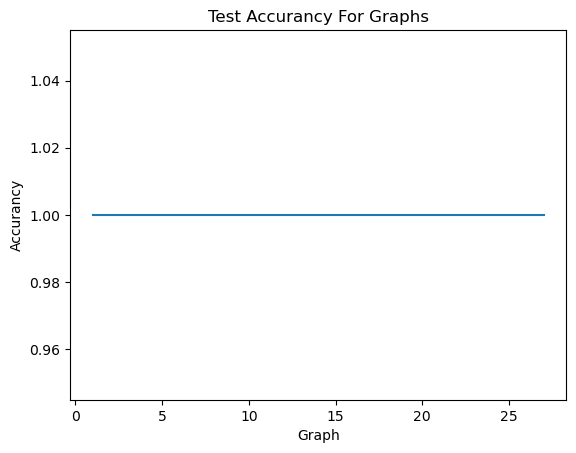

In [12]:
def gcn_test(gcn, graph_testloader, device):

    def get_acc(y_hat, y):
        return torch.sum(y_hat == y) / len(y)

    accs = []
    with torch.no_grad():
        for graph_idx, graph in enumerate(graph_testloader):
            x, y = graph.x.to(device), graph.y.to(device)
            edge_index, edge_weight = graph.edge_index.to(device), graph.edge_weight.to(device)
            y_hat = gcn(x, edge_index, edge_weight).argmax(axis=-1)
            accs.append(get_acc(y_hat, y).item())
            print(f"在第 {graph_idx+1} 张测试图中, 测试正确率为:{accs[-1]*100:.2f}%")
    print(f"在测试集上的平均正确率:{sum(accs) / len(accs)*100:.2f}%")
    plt.plot(list(range(1, len(graph_testloader)+1)), accs)
    plt.xlabel('Graph')
    plt.ylabel('Accurancy')
    plt.title('Test Accurancy For Graphs')

gcn_test(gcn, graph_testloader, args.device)